In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Physics-informed regularization: Solving PDEs

## Objectives

+ Learn how to solve PDEs with neural networks.

This notebook replicates some of the results of [Lagaris et al. 1998)](https://arxiv.org/pdf/physics/9705023.pdf).

In [2]:
import numpy as np
import torch
import torch.nn as nn

# This is useful for taking derivatives:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

## Example: Solving PDEs

consider a PDE of the form:

$$
\frac{\partial^2}{\partial x^2}\Psi(x,y) + \frac{\partial^2}{\partial y^2}\Psi(x,y) = f(x,y),
$$

on $(x,y) \in [0,1]^2$ with Dirichlet boundary conditions:

$$
\Psi(0, y) = f_0(y),
$$

$$
\Psi(1, y) = f_1(y),
$$

$$
\Psi(x, 0) = g_0(x),
$$

and

$$
\Psi(x, 1) = g_1(x).
$$

We write:

$$
\hat{\Psi}(x,y;\theta) = A(x,y) + x(1-x)y(1-y)N(x,y;\theta),
$$

where $A(x,y)$ is chosen to satisfy the boundary conditions:

$$
A(x,y) = (1-x)f_0(y) + xf_1(y) + (1-y)\{g_0(x) - [(1-x)g_0(0)+xg_0(1)]\} + y\{g_1(x)-[(1-x)g_1(0) + xg_1(1)]\}.
$$

The loss function that we need to minimize is:

$$
L(\theta) = \int_{[0,1]^2} \left\{\frac{\partial^2}{\partial x^2}\hat{\Psi}(x,y;\theta) + \frac{\partial^2}{\partial y^2}\hat{\Psi}(x,y;\theta) - f(x,y)\right\}^2dxdy.
$$

Here is code that solves the same problem:

In [3]:
class PDEProblemDC(object):
    """
    A class representing PDE with DC boundary.
    
    :param rhs:               The right hand side of the equation.
                              This must be a function with signature rhs((x,y))
                              where t is time and y is the state of the system.
    :param f0:                Left boundary conditon.
    :param f1:                Right boundary condition.
    :param g0:                Bottom boundary conditon.
    :param g1:                Top boundary condition.
    :param net:               A neural network for representing the solution. This must have
                              two-dimensional input and one-dimensional output.
    """
    
    def __init__(self, rhs, f0, f1, g0, g1, net):
        self._rhs = rhs
        self._f0 = f0
        self._f1 = f1
        self._g0 = g0
        self._g1 = g1
        self._net = net
        # This implements a function that satisfies the boundary conditions exactly
        g00 = self.g0(torch.zeros((1,)))[0]
        g01 = self.g0(torch.ones((1,)))[0]
        g10 = self.g1(torch.zeros((1,)))[0]
        g11 = self.g1(torch.ones((1,)))[0]
        def A(x):
            res = (1.0 - x[:, 0]) * self.f0(x[:, 1])
            res += x[:, 0] * self.f1(x[:, 1])
            res += (1.0 - x[:, 1]) * (self.g0(x[:, 0]) - ((1.0 - x[:, 0]) * g00 + x[:, 0] * g01))
            res += x[:, 1] * (self.g1(x[:, 0]) - ((1.0 - x[:, 0]) * g10 + x[:, 0] * g11))
            return res
        self._A = A
        self._solution = lambda x: self.A(x) + x[:, 0] * (1.0 - x[:, 0]) * x[:, 1] * (1.0 - x[:, 1]) * self.net(x)[:, 0]
    
    @property
    def rhs(self):
        return self._rhs
    
    @property
    def f0(self):
        return self._f0
    
    @property
    def f1(self):
        return self._f1
    
    @property
    def g0(self):
        return self._g0
    
    @property
    def g1(self):
        return self._g1
    
    @property
    def A(self):
        return self._A
    
    @property
    def net(self):
        return self._net
    
    @property
    def solution(self):
        """
        Return the solution function.
        """
        return self._solution
    
    def squared_residual_loss(self, X):
        """
        Returns the squared residual loss at spatial locations X.
        
        :param T:    Must be a 1D torch tensor.
        """
        X.requires_grad = True
        sol = self.solution(X)
        A = self.A(X)
        sol_x = grad(sol, X)
        # Get the second derivatives
        sol_xx = grad(sol_x[:, 0], X)[:, 0]
        sol_yy = grad(sol_x[:, 1], X)[:, 1]
        rhs = self.rhs(X)
        return torch.mean((sol_xx + sol_yy - rhs) ** 2)
    
    def solve_lbfgs(self, X_colloc, max_iter=10):
        """
        Solve the problem by minimizing the squared residual loss.
        
        :param T_colloc: The collocation points used to solve the problem.
        """
        optimizer = torch.optim.LBFGS(self.net.parameters())

        # Run the optimizer
        def closure():
            optimizer.zero_grad()
            l = self.squared_residual_loss(X_colloc)
            l.backward()
            return l
        for i in range(max_iter):
            res = optimizer.step(closure)
            print(res)
            

def plot_contour(ex, true_sol):
    """Plot the contour of the true solution and the approximation."""
    xx = np.linspace(0, 1, 64)
    X, Y = np.meshgrid(xx, xx)
    X_flat = torch.Tensor(np.hstack([X.flatten()[:, None], Y.flatten()[:, None]]))
    Z_flat = ex.solution(X_flat).detach().numpy()
    Z_t_flat = true_sol(X_flat)
    Z_t_flat = Z_t_flat.detach().numpy()
    Z = Z_flat.reshape(64, 64)
    Z_t = Z_t_flat.reshape(64, 64)
    fig, ax = plt.subplots()
    c = ax.contourf(X, Y, Z)
    ax.set_title("Neural network solution")
    plt.colorbar(c)
    fig, ax = plt.subplots()
    c = ax.contourf(X, Y, Z_t)
    ax.set_title("True solution")
    plt.colorbar(c)

And here is how to solve it with neural networks:

In [4]:
# Problem 5 of Lagaris
rhs = lambda x: torch.exp(-x[:, 0]) * (x[:, 0] - 2.0 + x[:, 1] ** 3 + 6.0 * x[:, 1])
f0 = lambda x2: x2 ** 3
f1 = lambda x2: (1.0 + x2 ** 3) * np.exp(-1.0)
g0 = lambda x1: x1 * torch.exp(-x1)
g1 = lambda x1: torch.exp(-x1) * (x1 + 1.0)
ex5 = PDEProblemDC(rhs, f0, f1, g0, g1,
                   nn.Sequential(nn.Linear(2, 10), nn.Sigmoid(), nn.Linear(10,1, bias=False)))
x = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, x)
X_flat = torch.Tensor(np.hstack([X.flatten()[:, None], Y.flatten()[:, None]]))
ex5.solve_lbfgs(X_flat)

tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(9.8839e-05, grad_fn=<MeanBackward0>)
tensor(1.4855e-05, grad_fn=<MeanBackward0>)
tensor(6.9040e-06, grad_fn=<MeanBackward0>)
tensor(1.5973e-06, grad_fn=<MeanBackward0>)
tensor(6.9797e-07, grad_fn=<MeanBackward0>)
tensor(5.1638e-07, grad_fn=<MeanBackward0>)
tensor(4.4831e-07, grad_fn=<MeanBackward0>)
tensor(4.4608e-07, grad_fn=<MeanBackward0>)


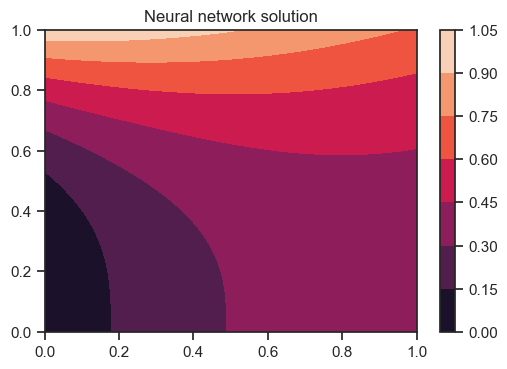

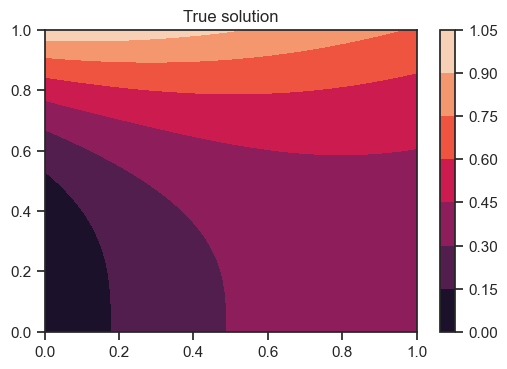

In [5]:
ex5_true_sol = lambda x: torch.exp(-x[:, 0]) * (x[:, 0] + x[:, 1] ** 3)
plot_contour(ex5, ex5_true_sol)

In [13]:
# Problem 6 of Lagaris
a = 3.0
def rhs(x):
    tmp1 = torch.exp(-(a * x[:, 0] + x[:, 1]) / 5.0)
    tmp2 = (-4.0 / 5.0 * a ** 3 * x[:, 0] - 2.0 / 5.0 + 2.0 * a ** 2) * torch.cos(a ** 2 * x[:, 0] ** 2 + x[:, 1])
    tmp2 += (1.0 / 25.0 - 1.0 - 4.0 * a ** 4 * x[:, 0] ** 2 + a ** 2 / 25.0) * torch.sin(a ** 2 * x[:, 0] ** 2 + x[:, 1])
    return tmp1 * tmp2
ex6_true_sol = lambda x: torch.exp(-(a * x[:, 0] + x[:, 1]) / 5.0) * torch.sin(a ** 2 * x[:, 0] ** 2 + x[:, 1])
f0 = lambda x2: ex6_true_sol(torch.stack((torch.zeros_like(x2), x2), dim=1))
f1 = lambda x2: ex6_true_sol(torch.stack((torch.ones_like(x2), x2), dim=1))
g0 = lambda x1: ex6_true_sol(torch.stack((x1, torch.zeros_like(x1)), dim=1))
g1 = lambda x1: ex6_true_sol(torch.stack((x1, torch.ones_like(x1)), dim=1))
net = nn.Sequential(nn.Linear(2, 10), nn.Sigmoid(), nn.Linear(10, 1, bias=False))
ex6 = PDEProblemDC(rhs, f0, f1, g0, g1, net)
x = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, x)
X_flat = torch.Tensor(np.hstack([X.flatten()[:, None], Y.flatten()[:, None]]))
# Does not always work because of local minima.
# Try multiple times.
ex6.solve_lbfgs(X_flat, max_iter=10)

tensor(28.7037, grad_fn=<MeanBackward0>)
tensor(28.6589, grad_fn=<MeanBackward0>)
tensor(28.7512, grad_fn=<MeanBackward0>)
tensor(28.7028, grad_fn=<MeanBackward0>)
tensor(28.7028, grad_fn=<MeanBackward0>)
tensor(28.7028, grad_fn=<MeanBackward0>)
tensor(28.7028, grad_fn=<MeanBackward0>)
tensor(28.7353, grad_fn=<MeanBackward0>)
tensor(28.7353, grad_fn=<MeanBackward0>)
tensor(28.7941, grad_fn=<MeanBackward0>)


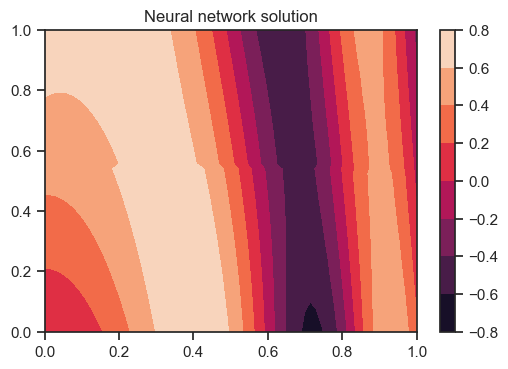

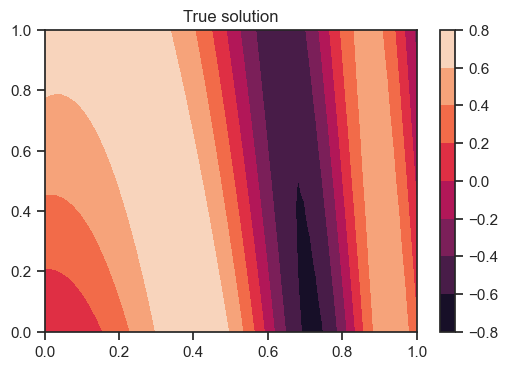

In [14]:
plot_contour(ex6, ex6_true_sol)

### Questions

Feel free to skip this as it can be hard if you are not expert with Python. 

+ Add a method to the class `PDEProblemDC` that uses stochastic gradient descent to solve the same problems. Once you are done, rerun the problems above with your code.
+ According to the [Dirchlet principle](https://en.wikipedia.org/wiki/Dirichlet%27s_principle#:~:text=In%20mathematics%2C%20and%20particularly%20in,a%20solution%20to%20Poisson's%20equation.), the solution of the PDE:

$$
\frac{\partial^2}{\partial x^2}\Psi(x,y) + \frac{\partial^2}{\partial y^2}\Psi(x,y) = f(x,y),
$$

minimizes the energy functional:

$$
J[\Psi] = \int_{[0,1]^2} \left[\frac{1}{2}\parallel \nabla \Psi\parallel^2 + \Psi f\right]dxdy,
$$

subject to the boundary conditions.
This means that you can solve the problem by minimizing the loss function:

$$
J(\theta) = \int_{[0,1]^2} \left[\frac{1}{2}\parallel \nabla \hat{\Psi}(x,y;\theta)\parallel^2 + \hat{\Psi}(x,y;\theta) f(x,y)\right]dxdy.
$$

Add this functionality to the class `PDEProblemDC`.